In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from snapfish2 import MulFish
from snapfish2.impute.simulate import TraceSample, exp_covar
from snapfish2.impute.spatial import *

In [2]:
import matplotlib as mpl
# remove the top and right spines
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
# remove the border of legend
mpl.rcParams["legend.frameon"] = False
# mpl.rcParams["legend.loc"] = (1, 0.5)
cmap = plt.get_cmap("seismic_r")
cmap.set_bad("white")
pal = sns.color_palette("pastel")

In [3]:
%reload_ext autoreload
%autoreload 2

In [7]:
N, R = 1000, 50
loc = np.arange(R)[:,None]
K = exp_covar(loc - loc.T, 1e5, 1e2)

# restrict the rank of the matrix
KL, KV = np.linalg.eig(K)
r = 10
K = KV[:,:r]@np.diag(KL[:r])@KV[:,:r].T

A = matrixA(R)
Ktrf = (A@K.flat).reshape(R, R)

shifts = np.random.uniform(0, 1e8, (3, N))
# shifts = np.zeros((3, N))
ts = TraceSample(N=N, R=R, K=K, tau=[50, 50, 100], obs_p=0.5, shifts=shifts)

The parameters of the covariance function is important. If setting the over all scale to 1e3 instead of 1e4, then the sample covariance matrix will look like completely random.

In [9]:
Ss = {"Sloh":[], "Shet":[]}
for X in ts.samples:
    X = X - np.nanmean(X, axis=1)[:,None]
    Sloh = sample_covar_ma(X)
    Ss["Sloh"].append(Sloh)
    Shet = sample_covar_heteroPCA(Sloh, 10)
    Ss["Shet"].append(Shet)

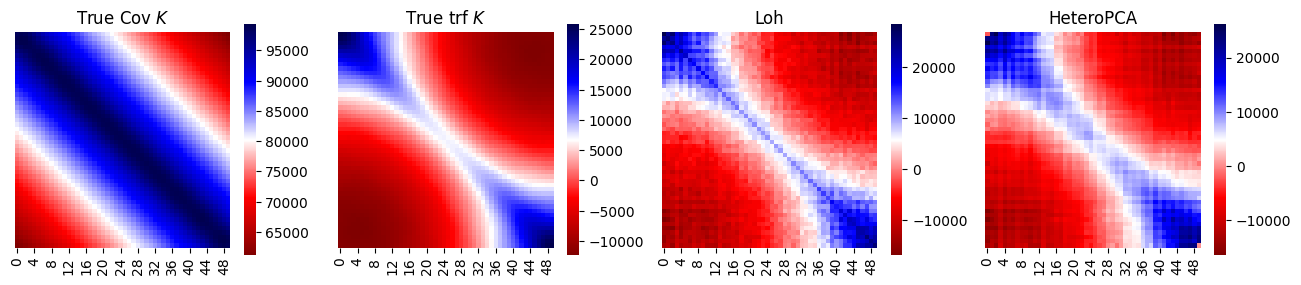

In [10]:
i = 0
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
hm_args = {"cmap":cmap, "square":True, "yticklabels":""}
hm_dict = {r"True Cov $K$":K, r"True trf $K$":Ktrf, r"Loh":Ss["Sloh"][i], r"HeteroPCA":Ss["Shet"][i]}
for i, (title, hm_val) in enumerate(hm_dict.items()):
    sns.heatmap(hm_val, ax=axes[i], **hm_args)
    axes[i].set(title=title)

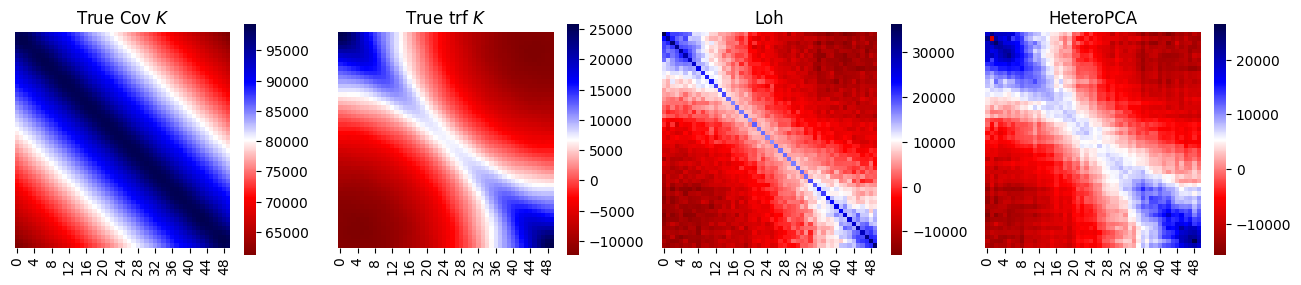

In [11]:
i = 2
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
hm_args = {"cmap":cmap, "square":True, "yticklabels":""}
hm_dict = {r"True Cov $K$":K, r"True trf $K$":Ktrf, r"Loh":Ss["Sloh"][i], r"HeteroPCA":Ss["Shet"][i]}
for i, (title, hm_val) in enumerate(hm_dict.items()):
    sns.heatmap(hm_val, ax=axes[i], **hm_args)
    axes[i].set(title=title)

In [12]:
tau_ls = []
for Sloh, Shet in zip(Ss["Sloh"], Ss["Shet"]):
    diag_diff = np.diag(Sloh) - np.diag(Shet)
    ns = np.sum(~np.isnan(ts.samples[0]), axis=0)
    tau_ls.append(np.sqrt(np.sum(ns*diag_diff)/np.sum(ns)))
tau_ls

[63.98836297341478, 57.99681309097292, 102.83286712280638]

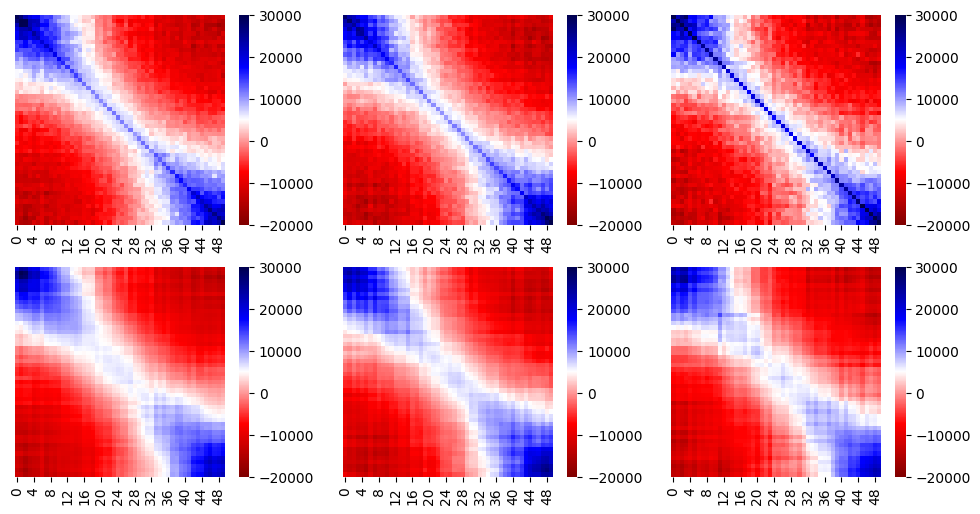

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for hm, ax in zip(Ss["Sloh"], axes[0]):
    sns.heatmap(hm, **hm_args, ax=ax, vmin=-2e4, vmax=3e4)
for hm, ax in zip(Ss["Shet"], axes[1]):
    sns.heatmap(hm, **hm_args, ax=ax, vmin=-2e4, vmax=3e4)

The z-axis has much coarse estimate as the measurement error is larger.

In [24]:
# path = "data/jie_aligned_takei_nature_2021/4DNFIS6MLXGA.csv"
path = "data/jie_aligned_takei_nature_2021/4DNFI7G3BWDF.csv"
data = MulFish(path).data
data["X"] = data["X"]*103
data["Y"] = data["Y"]*103
data["Z"] = data["Z"]*250

In [25]:
chrom = "chr2"
df = data[data["Chrom"]==chrom]
df = df.pivot(index="Trace_ID", values=["X", "Y", "Z"], columns="Chrom_Start")
arr = np.array([df[axis].values for axis in ["X", "Y", "Z"]])
print(f"N = {arr.shape[1]}, R = {arr.shape[2]}")

Ss = {"Sloh":[], "Shet":[]}
for X in arr:
    X = X - np.nanmean(X, axis=1)[:,None]
    Sloh = sample_covar_ma(X)
    Ss["Sloh"].append(Sloh)
    print(np.mean(np.triu(Sloh, 1)))
    Shet = sample_covar_heteroPCA(Sloh)
    Ss["Shet"].append(Shet)

tau_ls = []
for Sloh, Shet in zip(Ss["Sloh"], Ss["Shet"]):
    diag_diff = np.diag(Sloh) - np.diag(Shet)
    ns = np.sum(~np.isnan(arr[0]), axis=0)
    tau_ls.append(np.sqrt(np.sum(ns*diag_diff)/np.sum(ns)))
tau_ls

N = 595, R = 185
-113.73607736461335
-105.6922696054075
-109.56423522427377


[70.22919253939415, 63.87953371785466, 77.9673889412918]

In [34]:
tce = TraceCovEstimator(data)
tce.estimate_all_regions(r=2)

chr1: N = 750, R = 60
chr2: N = 667, R = 60
chr3: N = 693, R = 60
chr4: N = 639, R = 60
chr5: N = 841, R = 60
chr6: N = 722, R = 60
chr7: N = 979, R = 60
chr8: N = 593, R = 60
chr9: N = 676, R = 60
chr10: N = 671, R = 60
chr11: N = 742, R = 60
chr12: N = 638, R = 60
chr13: N = 730, R = 60
chr14: N = 617, R = 60
chr15: N = 606, R = 60
chr16: N = 705, R = 60
chr17: N = 646, R = 60
chr18: N = 611, R = 60
chr19: N = 582, R = 60
chrX: N = 440, R = 60


In [35]:
tce.estimate_K()

In [36]:
np.sqrt(tce.tau_sq_hat)

array([33.25972672, 31.99271392, 40.53958065])

<Axes: >

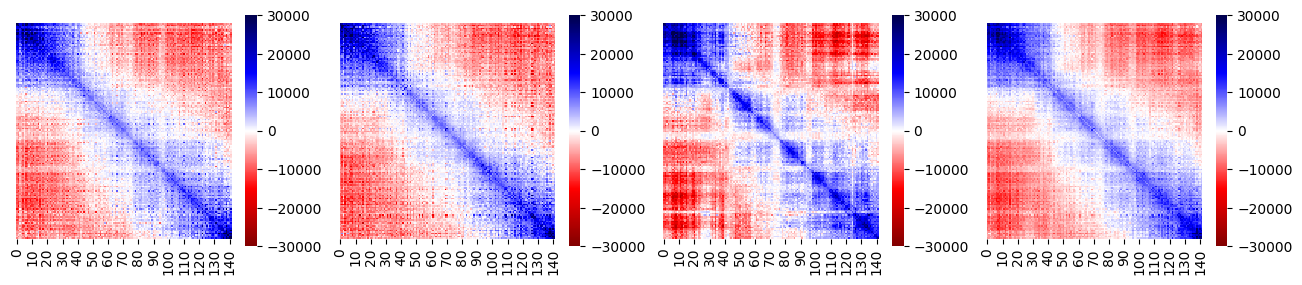

In [31]:
chrom = "chr7"
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
for hm, ax in zip(tce._cov_initial[chrom], axes[:-1]):
    sns.heatmap(hm, **hm_args, ax=ax, vmin=-3e4, vmax=3e4)
sns.heatmap(tce.cov_estimates[chrom], **hm_args, ax=axes[-1], vmin=-3e4, vmax=3e4)

In [125]:
df = data[data["Chrom"]==chrom]
tid = pd.unique(df["Trace_ID"])[0]
df = df[df["Trace_ID"]==tid]
coors = df[["X", "Y", "Z"]].values.T
for i, coor in enumerate(coors):
    na_mask = ~np.isnan(coor)
    inv = tce.prec_estimates[chrom][i][na_mask,:][:,na_mask]
    k = tce.cov_estimates[chrom][:,na_mask]


In [195]:
np.sum(na_mask)

61

In [139]:
k = tce.cov_estimates[chrom][1][na_mask] + tce.tau_sq_hat[i]/ tce.cov_estimates[chrom].shape[0]
np.sum(k@inv)

0.025381731121572423